# Identifying Melanoma in Skin Lesion Images

### Solution to the 2020 SIIM-ISIC Melanoma Classification Challenge

By Reynaldo Vazquez <br>
[rexvaz.com](https://rexvaz.com/)<br>
August 2020 
<br><br>

This notebook contains my solution to the [SIIM-ISIC Melanoma Classification](https://www.kaggle.com/c/siim-isic-melanoma-classification) competition hosted by [Kaggle](https://www.kaggle.com/), The Society for Imaging Informatics in Medicine ([SIIM](https://siim.org/)), and The International Skin Imaging Collaboration ([ISIC](https://www.isic-archive.com/)) that ended on August 17, 2020. The goal of the competition was to identify melanoma in images of skin lesions.

The evaluation metric used is the [area under the ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) between the predicted probability and the observed target. 

## Model

My final submission, which ranked top 11 percent in the competition with a private test AUC of 0.9363, consisted on an ensemble of 15 CNN classifiers as follows.

- 5 cross-validation splits were used to train 3 different EfficientNet based models. EfficientNet B3, B4, and B6.
- All classifiers were trained using Tensorflow Keras 2.x on Google Colab TPUs
- All used either imagenet or noisy-student pre-trained weights.
- Learning rate schedule with warm-up, constant, and exponential decay.
- All classifiers trained with either Rectified-Adam (Radam) or Adam with Nesterov Momentum (Nadam) optimizers. 
- Binary Cross-Entropy loss with 5% label smoothing was used throughout.


## Data

For training on TPU I used data (images, labels) contained in TFRecords created and made available by Chris Deotte. The training dataset consisted of the [official 2020 competition data](https://www.kaggle.com/cdeotte/melanoma-1024x1024) and I expanded it with the data from the [2018 competition](https://www.kaggle.com/cdeotte/isic2019-768x768). The data in these TFRecs was distributed so that:

- All images from a single patient are contained within a TFRecord.
- All TFRecords contain similar proportions of benign/malignant cases.
- Image counts, and image counts per patient are balanced across TFRecords. 

The TFRecords' data distribution features carried-over into the cross-validation splits.

TFRecords were processed using Tensorflow Dataset API to support TPU training. 
- Images were resized to match the original corresponding EfficientNet version size.
- Images were randomly augmented during training. Augmentations consisted of:
    - Zoom-in, rotate, shear, horizontal and vertical flip, hue, brightness, saturation, and contrast. 
- Since the dataset is heavily unbalanced i.e. malignant cases make up less than 2 percent of images, I oversampled malignant cases by a factor of 4. 
- Data was divided in 5 cross-validation folds. The within-fold (i.e. training) part of each fold was complemented with the 2018 data, while the out-of-fold (OOF) was not. 

## Inference and Post-Processing
Inference was made with un-augmented images as well as with up to 30 random test time augmentations (TTA) with each of the 15 classifiers. 

- Predictions across augmentations were weighted equally within each classifier. 
- Test predictions across EfficientNet versions for models trained within each fold were weighted according to their performance on their corresponding OOF (validation) data. This yielded 5 predictions, each corresponding to 1 of the 5 cross-validation folds.
- The 5 test predictions above were then weighted equally (i.e. simple-averaged) to yield a single prediction. 


## **Credits**:
- Thanks to **The Society for Imaging Informatics in Medicine**, **The International Skin Imaging Collaboration**, and **Kaggle** for hosting this competition and for making this data available. Thanks to the **Kaggle community** for great insights and very valuable guidance.

- Pavel Yakubovskiy's (qubvel) [EfficientNet library](https://github.com/qubvel/efficientnet) was used to set up all classifiers in this notebook. The pre-trained imagenet and noisy-student weights also come from his library. 

- Wei Hao Khoong's Notebook [[SIIM-ISIC] Multiple Model Training + Stacking](https://www.kaggle.com/khoongweihao/siim-isic-multiple-model-training-stacking) provided me great insight into TPU training, TensorFlow 2.x, Dataset API, as well as model stacking. 

- The TFRecords used for training come from Chris Deotte's Kaggle datasets [Melanoma TFRecords 1024x1024](https://www.kaggle.com/cdeotte/melanoma-1024x1024) for the 2020 data, and [ISIC 2019 TFRecords 768x768](https://www.kaggle.com/cdeotte/isic2019-768x768) for the 2018 data.

- Chris Deotte's notebook [Triple Stratified KFold with TFRecords](https://www.kaggle.com/cdeotte/triple-stratified-kfold-with-tfrecords/). Not only it was an inspiration, but it provided great guidance into the developing of this notebook. Also, the augmentation functions for image shear and rotate used here were adapted from his notebook. 


## Reproduce Notebook (Instructions)

To reproduce this notebook it is required that the data GCS paths below be updated by following the following steps. 

1. Navigate to this [link](https://www.kaggle.com/c/siim-isic-melanoma-classification/data), sign in (Kaggle account required) and agree to the data use terms by joining the competition.
2. Create a new Kaggle notebook. 
3. Attach the following 2 datasets to the notebook by clicking the `Add Data` link near the upper right corner.
    - [Melanoma TFRecords 1024x1024](https://www.kaggle.com/cdeotte/melanoma-1024x1024)
    -[ISIC 2019 TFRecords 768x768](https://www.kaggle.com/cdeotte/isic2019-768x768)

4. Paste and run the code below into the new notebook you created.
```
from kaggle_datasets import KaggleDatasets
GCS_PATH_2020 = KaggleDatasets().get_gcs_path('melanoma-1024x1024')
print(GCS_PATH_2020)
GCS_PATH_2019 = KaggleDatasets().get_gcs_path('isic2019-768x768')
print(GCS_PATH_2019)
```
5. Use the printed links to replace the GCS Paths in this notebook. Note these links will expire within a few days. 

Once the GCS Paths have been updated, make sure TPU is chosen as a hardware accelerator and run all. 

# Setup

In [1]:
#@markdown Fix for Colab + Tensorflow 2.3 TPU issues. Downgrades to Tensorflow
#@markdown 2.2 and fixes TPU compatibility.
# TF 2.3 on Colab TPU remain broken as of Nov 11, 2020
# refer to https://github.com/googlecolab/colabtools/issues/1470

tpu_temp_fix = True #@param {type:"boolean"}

if tpu_temp_fix:
    # Code to use TF 2.2.0
    # Needed for Colab TPU compatibility with TF 2.2.0
    !pip install tensorflow==2.2.0 tensorflow_gcs_config==2.2.0 --quiet
    import tensorflow as tf
    import requests, os
    resp = requests.post("http://{}:8475/requestversion/{}".format(os.environ["COLAB_TPU_ADDR"].split(":")[0], tf.__version__))
    if resp.status_code != 200:
        print("Failed to switch the TPU to TF {}".format(version))
    print("\nTensorflow version " + tf.__version__)

     |████████████████████████████████| 516.2MB 29kB/s 
     |████████████████████████████████| 399kB 46.9MB/s 
     |████████████████████████████████| 3.0MB 38.0MB/s 
     |████████████████████████████████| 460kB 35.9MB/s 

Tensorflow version 2.2.0


### Required Libraries

In [2]:
import os, sys, math, pathlib, re, gc, time, random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow_addons as tfa

!pip install -q efficientnet
import efficientnet.tfkeras as efn
!pip install -q gcsfs

print("\nTensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE 

!wget -q https://raw.githubusercontent.com/reyvaz/SIIM-ISIC-Melanoma-Identification-2020/master/utils.py
from utils import *

     |████████████████████████████████| 51kB 2.9MB/s 
     |████████████████████████████████| 92kB 4.8MB/s 
     |████████████████████████████████| 1.3MB 9.9MB/s 
     |████████████████████████████████| 143kB 25.1MB/s 
     |████████████████████████████████| 296kB 24.1MB/s 

Tensorflow version 2.2.0


### TPU Distribution Strategy

In [3]:
%%capture
#@markdown Distribution strategy
try: tpu
except:
    try:
        # TPU detection. No parameters necessary if TPU_NAME environment 
        # variable is set.
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        tpu = None
        print('TPU not found')
    if tpu:
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        if float(tf.__version__[:3]) < 2.3:
            strategy = tf.distribute.experimental.TPUStrategy(tpu) # for tf 2.2
        else: strategy = tf.distribute.TPUStrategy(tpu) # for tf 2.3
    else:
        # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
        strategy = tf.distribute.get_strategy()

    # os.getenv('TPU_NAME')
    

INFO:tensorflow:Initializing the TPU system: grpc://10.127.136.194:8470
INFO:tensorflow:Clearing out eager caches
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO

### Global Variables, GCS Paths, and Cross-Validation Distribution





In [4]:
N_CHANNELS = 3
N_CLASSES = 1 # use 1 for binary 

REPLICAS = strategy.num_replicas_in_sync
IMAGES_PER_REPLICA = 16 
BATCH_SIZE = IMAGES_PER_REPLICA * REPLICAS

EPOCHS = 16
buffer_size = 10000 #(used for data shuffling OOM if too large)

**GCS Paths**

Update these 2 paths to reproduce, see instructions above.

In [5]:
GCS_PATH_2020 = 'gs://kds-e586f041bce9127f99a1ae5d801c07bc104d5cde20ee67f6df0c6962'
GCS_PATH_2019 = 'gs://kds-2e7f8b2f9698c65cb1e8711005a1af971fcc9ed5a063c184eddd747d'

In [6]:
#@title Process Files and Cross-Validation Folds
TRAIN_2020 = tf.io.gfile.glob(GCS_PATH_2020 + '/train*.tfrec')

legacy_files = tf.io.gfile.glob(GCS_PATH_2019 + '/*.tfrec')
# Filenames ending in odd numbers correpond to 2018 files
# even numbers correspond to 2019
TRAIN_2018 = legacy_files[::2] 
TRAIN_2019 = legacy_files[1::2]

N_FOLDS = 5
skf = KFold(n_splits=N_FOLDS)
folds ={}
for fold,(idxT,idxV) in enumerate(skf.split(np.arange(15))):
    folds.update({fold: {'val': idxV, 'train': idxT}})

def get_fold_file_lists(fold, data_2018 = True):
    TRAINING_FILENAMES = [TRAIN_2020[i] for i in fold['train']]
    VALIDATION_FILENAMES = [TRAIN_2020[i] for i in fold['val']]
    if data_2018: 
        TRAINING_FILENAMES = [val for pair in zip(TRAINING_FILENAMES, TRAIN_2018) for val in pair]
        TRAINING_FILENAMES.insert(5, TRAIN_2018[-1])
        TRAINING_FILENAMES.insert(15, TRAIN_2018[-2])
        TRAINING_FILENAMES.insert(21, TRAIN_2018[-3])
    return TRAINING_FILENAMES, VALIDATION_FILENAMES

del fold

# Process TFRecs (Dataset API Pipeline)

In [7]:
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        'image': tf.io.FixedLenFeature([], tf.string), 
        'image_name' : tf.io.FixedLenFeature([], tf.string),
        'target': tf.io.FixedLenFeature([], tf.int64), 
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    return example['image'], example['image_name'], example['target'] 

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        'image': tf.io.FixedLenFeature([], tf.string), 
        'image_name': tf.io.FixedLenFeature([], tf.string), 
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    return example['image'], example['image_name']

def load_dataset(filenames, labeled = True, ordered = False):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    if not ordered: 
        ignore_order = tf.data.Options()
        ignore_order.experimental_deterministic = False 
        dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord if labeled else 
                          read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    return dataset

In [8]:
def decode_image(image_data, label, resize, target_size):
    # Used for the validation set (for now)
    image = tf.image.decode_jpeg(image_data, channels=N_CHANNELS)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    if resize:
        image = tf.image.resize(image, target_size)
    image = tf.reshape(image, [*target_size, N_CHANNELS]) # explicit size NEEDED for TPU
    return image, label

def resize_transforms(image, label_or_id, resize, target_size):
    # for training, 2nd arg will be a label; for testing, image_id
    # Initial resize related transforms, perform before data_augment
    image = tf.image.decode_jpeg(image, channels=N_CHANNELS)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range

    # some images will be zoomed from the orig size, then resized, to preserve quality. 
    # by central_cropping + resizing, this effectively zooms, possibly losslessly,
    # depending on the difference between original and target size. 
    #if  tf.keras.backend.random_bernoulli((1,), p=0.3) > 0:
    if tf.keras.backend.random_binomial((1,), p=0.3) > 0:
        image = tf.image.central_crop(image, 0.6)
        image = tf.image.resize(image, target_size)
    elif tf.keras.backend.random_binomial((1,), p=0.25) > 0:
    #elif tf.keras.backend.random_bernoulli((1,), p=0.25) > 0:
        image = tf.image.central_crop(image, 0.9)
        image = tf.image.resize(image, target_size)
    elif resize:
        image = tf.image.resize(image, target_size)
    image = tf.reshape(image, [*target_size, N_CHANNELS]) # explicit size NEEDED for TPU
    return image, label_or_id

def data_augment(image, label_or_id, DIM): 
    # during TTA, label_or_id will be image_name for test set.
    if tf.keras.backend.random_binomial((1,), p=0.4) > 0:
    #if tf.keras.backend.random_bernoulli((1,), p=0.4) > 0:
        image = rotate_img(image, DIM = DIM)
    elif tf.keras.backend.random_binomial((1,), p=0.2) > 0:
    #elif tf.keras.backend.random_bernoulli((1,), p=0.2) > 0:
        image = shear_img(image, DIM = DIM)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_hue(image, 0.025)
    image = tf.image.random_saturation(image, 0.6, 1.4)
    image = tf.image.random_contrast(image, 0.7, 1.4)
    image = tf.image.random_brightness(image, 0.1)
    return image, label_or_id

In [9]:
def get_training_dataset(file_list, dim):
    dataset = load_dataset(file_list)
    dataset = dataset.map(lambda image, image_name, target: 
                          resize_transforms(image, target, True, [dim, dim]), 
                          num_parallel_calls=AUTO)
    dataset = dataset.map(lambda image, target: 
                          data_augment(image, target, DIM = dim), 
                          num_parallel_calls=AUTO)
    #dataset = dataset.cache()  
    dataset = dataset.repeat() 
    dataset = dataset.shuffle(buffer_size = buffer_size)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) 
    return dataset

def get_validation_dataset(file_list, dim, ordered = False):
    # uses decode_image instead of resize_transform & data_augment
    # it is used for validation set used during training (i.e. no augmentations)
    dataset = load_dataset(file_list, ordered = ordered)
    dataset = dataset.map(lambda image, image_name, target: 
                          decode_image(image, target, True, [dim,dim]),
                          num_parallel_calls=AUTO)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache() 
    dataset = dataset.prefetch(AUTO) 
    return dataset

def build_datasets(model_dict):
    fold = model_dict['fold']
    DIM = model_dict['DIM']
    # Fold Filenames, Counts
    TRAINING_FILENAMES, VALIDATION_FILENAMES = get_fold_file_lists(folds[fold], data_2018=True)
    NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
    NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
    STEPS_PER_EPOCH = np.ceil(NUM_TRAINING_IMAGES/BATCH_SIZE).astype(int)

    # Dataset
    train_dataset = get_training_dataset(TRAINING_FILENAMES, DIM)
    valid_dataset = get_validation_dataset(VALIDATION_FILENAMES, dim = DIM, ordered = False)
    print('\n')
    describe_ds(train_dataset)
    describe_ds(valid_dataset)
    return train_dataset, valid_dataset, STEPS_PER_EPOCH, [NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES]

# Data Visualization

In [10]:
gen_examples = True #@param {type:"boolean"}
num_batches = 5 #@param [2, 3, 5, 10] {type:'raw'}

if gen_examples:
    temp_filenames, _ = get_fold_file_lists(folds[4], data_2018=False)
    temp_dataset = get_training_dataset(temp_filenames, 224)
    raw_tuples = generate_examples(ds = temp_dataset, n_batches = num_batches)
    

In [11]:
idx = -1

Label: Benign
Image size: (224, 224, 3)


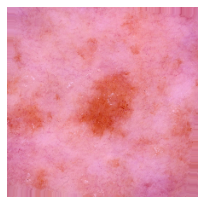

In [12]:
idx +=1
if gen_examples:
    if idx >= len(raw_tuples): idx = -1
    example_tuple = raw_tuples[idx]
    plot_example(example_tuple, print_size=True)
else: print('examples have not been generated')

# Model

In [13]:
def build_model(base, n_classes, shape, head_dropout = False):
    inp = L.Input(shape=shape)
    x = base(inp)
    x = L.GlobalAveragePooling2D()(x)

    if head_dropout:
        x = L.Dropout(head_dropout)(x)

    x_out = L.Dense(n_classes, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inp, outputs=x_out, 
                           name='{}_base_model'.format(base.name.title()))
    return model

def ensemble_component(model_dict):
    # Get Specs
    base_model = model_dict['base_model']
    DIM = model_dict['DIM']
    weights = model_dict['weights']
    opt = model_dict['opt']
    head_dropout = model_dict['head_dropout']
    INPUT_SHAPE = (DIM, DIM, N_CHANNELS)

    # Build Model
    K.clear_session()
    with strategy.scope():
        base = base_model(weights=weights, include_top=False, 
                          input_shape=INPUT_SHAPE)                                       
        model = build_model(base, N_CLASSES, INPUT_SHAPE, 
                            head_dropout = head_dropout) 
        model.compile(optimizer=opt, loss=loss, metrics=['AUC']) 
    return model, base.name

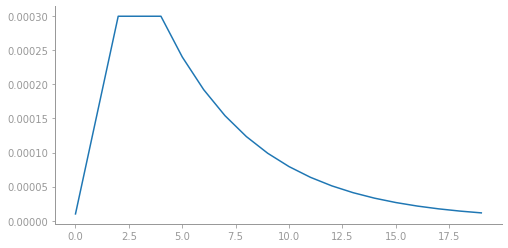

In [14]:
#@title Learning Rate Schedule, Loss
lr_params =  [1e-5,  3e-4,  1e-6, 2, 2, 8e-1]

def lrfn(epoch, lr_params = lr_params):
    lr_start, lr_max, lr_min, lr_ramp_ep, lr_sus_ep, lr_decay = lr_params
    if epoch < lr_ramp_ep:
        lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
    elif epoch < lr_ramp_ep + lr_sus_ep:
        lr = lr_max 
    else:
        lr = (lr_max - lr_min)*lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
    return lr

def lr_schedule_builder(params):
    return tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: lrfn(epoch, params), verbose=False) 

lr_sched = lr_schedule_builder(lr_params)

label_smoothing = 0.05
loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=label_smoothing) 

plot_lr_timeline(lrfn, lr_params, num_epochs = EPOCHS)

In [15]:
#@markdown Summary and Log Function
def sess_summary(model_dict, counts, dataset_deets = True): 
    DIM = model_dict['DIM']
    INPUT_SHAPE = (DIM, DIM, N_CHANNELS)
    log_name = '{}_F{}_summary.txt'.format(model_dict['name'], model_dict['fold'])
    with open(log_name, 'w') as f:
        f.write('\nBase: {}'.format(base_name.title()))
        f.write('\nFold num: {}'.format(model_dict['fold']))
        f.write('\nWeights: {}\n'.format(model_dict['weights']))

        if dataset_deets:
            f.write('\nValidation shards: {}'.format(folds[model_dict['fold']]['val']))
            f.write('\nTotal training images: {}'.format(counts[0]))
            f.write('\nTotal val images: {}'.format(counts[1]))
            f.write('\nBatch size: {}'.format(BATCH_SIZE))
            f.write('\nMax number of epochs: {}'.format(EPOCHS))
            f.write('\nSteps per epoch: {}\n'.format(STEPS_PER_EPOCH))

        f.write('\nTPU implemented: {}'.format('Yes' if tpu != None else 'No'))
        f.write('\nNumber of replicas: {}'.format(strategy.num_replicas_in_sync))
        f.write('\nSize of input: {}'.format(INPUT_SHAPE))
        f.write('\nOptimizer: {}'.format(str(model_dict['opt']).split('.')[-2].title()))
        f.write('\nLR strategy: {}'.format(str(lr_sched).split('.')[4].split(' ')[0]))
        f.write('\nLR sched params: {}'.format(lr_params))
        f.write('\nLoss: {}'.format(str(loss).split('.')[4].split(' ')[0]))
        f.write('\nLabel smoothing: {}\n\n'.format(label_smoothing))
    !cat {log_name}

# Training

For expediency, only 2 classifiers are trained in this notebook. To train more or all of the individual classifiers include their dictionaries from the **Training Dictionaries (Training Parameters)** in the `ensemble_components` list below. 

PS: As I reran this notebook, it seems memory provided by Colab was reduced from 16GB to 8GB. This may cause out-of-memory (OOM) problems when training EfficientNetB6 based classifiers with the specified settings. A work-around for these issues would be reducing the variable `IMAGES_PER_REPLICA` and/or the image target size for these classifiers.

In [16]:
#@title Training Dictionaries (Training Parameters)
#@markdown - EfficientNet B3
EB3_F0 = {'base_model': efn_dict[3]['model'], 
            'DIM': efn_dict[3]['size'],
            'opt': opts['Nadam'],
            'weights': 'noisy-student',
            'head_dropout': 0.5, 
            'name': 'EB3',
            'fold': 0}  

EB3_F1 = {'base_model': efn_dict[3]['model'], 
            'DIM': efn_dict[3]['size'],
            'opt': opts['Nadam'],
            'weights': 'noisy-student',
            'head_dropout': False, 
            'name': 'EB3',
            'fold': 1}  

EB3_F2 = {'base_model': efn_dict[3]['model'], 
            'DIM': efn_dict[3]['size'],
            'opt': opts['Radam'],
            'weights': 'noisy-student',
            'head_dropout': False, 
            'name': 'EB3',
            'fold': 2}  

EB3_F3 = {'base_model': efn_dict[3]['model'], 
            'DIM': efn_dict[3]['size'],
            'opt': opts['Radam'],
            'weights': 'noisy-student',
            'head_dropout': 0.2, 
            'name': 'EB3',
            'fold': 3}

EB3_F4 = {'base_model': efn_dict[3]['model'], 
            'DIM': efn_dict[3]['size'],
            'opt': opts['Radam'],
            'weights': 'noisy-student',
            'head_dropout': False, 
            'name': 'EB4',
            'fold': 4}

#@markdown - EfficientNet B4 
EB4_F0 = {'base_model': efn_dict[4]['model'],
            'DIM': efn_dict[4]['size'],
            'opt': opts['Nadam'],
            'weights': 'noisy-student',
            'head_dropout': False,
            'name': 'EB4',
            'fold': 0}

EB4_F1 = {'base_model': efn_dict[4]['model'],
            'DIM': efn_dict[4]['size'],
            'opt': opts['Radam'],
            'weights': 'noisy-student',
            'head_dropout': False,
            'name': 'EB4',
            'fold': 1}

EB4_F2 = {'base_model': efn_dict[4]['model'],
            'DIM': efn_dict[4]['size'],
            'opt': opts['Nadam'],
            'weights': 'noisy-student',
            'head_dropout': False,
            'name': 'EB4',
            'fold': 2}

EB4_F3 = {'base_model': efn_dict[4]['model'], 
            'DIM': efn_dict[4]['size'],
            'opt': opts['Nadam'],
            'weights': 'noisy-student',
            'head_dropout': False,
            'name': 'EB4',
            'fold': 3}  

EB4_F4 = {'base_model': efn_dict[4]['model'], 
            'DIM': efn_dict[4]['size'],
            'opt': opts['Nadam'],
            'weights': 'noisy-student',
            'head_dropout': False, 
            'name': 'EB4',
            'fold': 4}

#@markdown - EfficientNet B6 
EB6_F0 = {'base_model': efn_dict[6]['model'],
            'DIM': efn_dict[6]['size'],
            'opt': opts['Nadam'],
            'weights': 'noisy-student',
            'head_dropout': False,
            'name': 'EB6',
            'fold': 0}

EB6_F1 = {'base_model': efn_dict[6]['model'],
            'DIM': efn_dict[6]['size'],
            'opt': opts['Radam'],
            'weights': 'noisy-student',
            'head_dropout': False,
            'name': 'EB6',
            'fold': 1}

EB6_F2 = {'base_model': efn_dict[6]['model'],
            'DIM': efn_dict[6]['size'],
            'opt': opts['Nadam'],
            'weights': 'noisy-student',
            'head_dropout': False,
            'name': 'EB6',
            'fold': 2}

EB6_F3 = {'base_model': efn_dict[6]['model'], 
            'DIM': efn_dict[6]['size'],
            'opt': opts['Nadam'],
            'weights': 'noisy-student',
            'head_dropout': 0.2,
            'name': 'EB6',
            'fold': 3}

EB6_F4 = {'base_model': efn_dict[6]['model'],
            'DIM': efn_dict[6]['size'],
            'opt': opts['Nadam'],
            'weights': 'noisy-student',
            'head_dropout': False,
            'name': 'EB6',
            'fold': 4}

In [17]:
ensemble_components = [EB3_F1, EB4_F1]

In [18]:
for component_dict in ensemble_components:
    model, base_name = ensemble_component(component_dict)
    train_dataset, valid_dataset, STEPS_PER_EPOCH, counts = build_datasets(component_dict)
    sess_summary(component_dict, counts, dataset_deets = True)

    weights_file = '{}_F{}_weights.h5'.format(component_dict['name'], component_dict['fold'])
    component_dict['weights_file'] = weights_file
    checkpoint = config_checkpoint(weights_file)

    history = model.fit(train_dataset, epochs=EPOCHS, verbose=True, 
                        steps_per_epoch=STEPS_PER_EPOCH,
                        callbacks=[checkpoint, lr_sched],
                        validation_data=valid_dataset)

43933696/43933088 [==============================] - 1s 0us/step


Dataset: shapes: ((None, 300, 300, 3), (None,)), types: (tf.float32, tf.int64)
Dataset: shapes: ((None, 300, 300, 3), (None,)), types: (tf.float32, tf.int64)

Base: Efficientnet-B3
Fold num: 1
Weights: noisy-student

Validation shards: [3 4 5]
Total training images: 39031
Total val images: 6520
Batch size: 128
Max number of epochs: 16
Steps per epoch: 305

TPU implemented: Yes
Number of replicas: 8
Size of input: (300, 300, 3)
Optimizer: Nadam
LR strategy: LearningRateScheduler
LR sched params: [1e-05, 0.0003, 1e-06, 2, 2, 0.8]
Loss: BinaryCrossentropy
Label smoothing: 0.05

Epoch 1/16
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
305/305 [==============================] - 108s 353ms/step - loss: 0.3393 - auc: 0.6321 - val_loss: 0.1850 - val_auc: 0.7980 - lr: 1.0000e-05
Epoch 2/16
305/305 [==============================] - 91s 298ms/step - loss: 0.2354 - auc: 0.8623 - val_loss: 0.1689 

# Performance Anaysis

In [19]:
#@markdown Rebuild Classifiers Functions (for Inference)
#@markdown - Build untrained classifier
def get_untrained_model(model_dict):
    # Get Specs
    base_model = model_dict['base_model']
    DIM = model_dict['DIM']
    INPUT_SHAPE = (DIM, DIM, N_CHANNELS)

    # Build Model
    K.clear_session()
    with strategy.scope():
        base = base_model(weights=None, include_top=False, input_shape=INPUT_SHAPE)                                       
        model = build_model(base, N_CLASSES, INPUT_SHAPE) 
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC']) 

    print('Built {} based model with random weights'.format(base.name.title()))
    return model
#@markdown - Load trained weights
def switch_weights(model, model_dict):
    weights_path = model_dict['weights_file']
    model.load_weights(weights_path)
    print('Assigned FOLD {} weights to {}-based model'.format(
        model_dict['fold'], model.name.split('_')[0]))
    return model

In [20]:
#@markdown Inference TFRecs Processing Functions
#@markdown - Unaugmented Dataset API Pipeline
#@markdown - Test Time Augmentation (TTA) Dataset API Pipeline

def unaugmented_val_dataset(fold_num, DIM, ordered = True):
    # Fold Filenames, Counts
    print('\nGetting validation filenames and dataset for FOLD {} and SIZE {}'.format(
        fold_num, DIM))
    VALIDATION_FILENAMES = get_fold_file_lists(folds[fold_num], data_2018=False)[1]
    NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
    # Dataset
    valid_dataset = get_validation_dataset(VALIDATION_FILENAMES, dim = DIM, 
                                           ordered = ordered)
    print('Number of validation images: {}'.format(NUM_VALIDATION_IMAGES))
    describe_ds(valid_dataset)
    return valid_dataset, VALIDATION_FILENAMES, NUM_VALIDATION_IMAGES

def tta_validation_datasets(file_list, dim):
    dataset = load_dataset(file_list, ordered = True) 
    # extract images and augment for TTA
    dataset_aug = dataset.map(lambda image, image_name, target: 
                          resize_transforms(image, target, True, [dim, dim]), 
                          num_parallel_calls=AUTO)
    dataset_aug = dataset_aug.map(lambda image, target: 
                          data_augment(image, target, DIM = dim), 
                          num_parallel_calls=AUTO)
    dataset_aug = dataset_aug.map(lambda image, target: image)
    dataset_aug = dataset_aug.repeat() # will repeat for TTA
    dataset_aug = dataset_aug.batch(BATCH_SIZE)
    dataset_aug = dataset_aug.prefetch(AUTO)
    dataset = dataset.prefetch(AUTO) # return this to extract names and targets
    return dataset_aug, dataset

In [21]:
#@markdown Prediction Function
def get_predictions(valid_dataset, valid_orig_imgs, valid_aug_imgs, TTA, NUM_VALIDATION_IMAGES, TTA_STEPS):
    print('\nMaking Predictions:')
    eval = model.evaluate(valid_dataset, verbose=True, return_dict=False) # evaluation as in training
    pred_orig = model.predict(valid_orig_imgs, verbose=1) # these are the predictions on the un-augmented valid set
    preds_aug = model.predict(valid_aug_imgs, steps=TTA_STEPS, verbose=1)[:TTA*NUM_VALIDATION_IMAGES,] # these are the predictions on the augmented valid set
    # slice will make sure I have the right number of predictions
    tta_preds = preds_aug.reshape((NUM_VALIDATION_IMAGES, TTA), order='F')
    return eval, pred_orig, tta_preds

In [22]:
#@markdown Folds Models Lists
models_fold_0 = [EB3_F0, EB4_F0, EB6_F0]
models_fold_1 = [EB3_F1, EB4_F1, EB6_F1]
models_fold_2 = [EB3_F2, EB4_F2, EB6_F2]
models_fold_3 = [EB3_F3, EB4_F3, EB6_F3]
models_fold_4 = [EB3_F4, EB4_F4, EB6_F4]

models_folds = [models_fold_0, models_fold_1, models_fold_2, 
                models_fold_3, models_fold_4]

The loop below will perform predictions en evaluation of the 2 classifiers trained above. To include more classifiers adjust the `folds_idx` and `efn_vers_idx` lists below accordingly. If training all classifiers, can simply uncomment/comment the alternative lines at the start of the OUTER and INNER `for` loops.




In [23]:
folds_idx = [1] # the index in models_folds of the fold to be used
efn_vers_idx = [0, 1] # the index of the efn version to be used 0 for B3, 1 for B4, 2 for B6

In [24]:
#@markdown Prediction and Evaluation Loop
TTA = 30 # Test time augmentation Steps 
cols = ['component', 'tf_eval', 'no_aug', 'tta_10', 'tta_20', 'tta_30', 'best']

aucsDF = pd.DataFrame(columns = cols)

# for fold_num, models_fold in enumerate(models_folds): # START OUTER LOOP
for fold_num in folds_idx: # START OUTER LOOP
    print('Processing models for FOLD {} \nGetting targets and names'.format(fold_num))

    models_fold = models_folds[fold_num]
    VALIDATION_FILENAMES = get_fold_file_lists(folds[fold_num], data_2018=False)[1]
    NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
    valid_ordered = tta_validation_datasets(VALIDATION_FILENAMES, dim = 100)[1] 
    # dim above is not relevant so choose anything, will only need the labels and ids

    # retrive the targets
    val_targets_ds = valid_ordered.map(lambda image, image_name, target: target)
    val_targets = np.array([target.numpy() for target in iter(val_targets_ds)])
    
    # retrieve image names
    val_names_ds = valid_ordered.map(lambda image, image_name, target: image_name)
    val_names = [image_name.numpy().decode("utf-8") for image_name in iter(val_names_ds)] 

    TTA_STEPS = np.ceil(TTA * NUM_VALIDATION_IMAGES/BATCH_SIZE).astype(int)
    assert TTA_STEPS*BATCH_SIZE >= NUM_VALIDATION_IMAGES*TTA
    print('TTA steps: {}, number of aug preds: {}, min aug preds required: {}'.format(
    TTA_STEPS, TTA_STEPS*BATCH_SIZE, NUM_VALIDATION_IMAGES*TTA))

    # Create one of this for each FOLD, put info of all 3 models here. 
    predsDF = pd.DataFrame({'image_name': val_names, 'target': val_targets})

    # for model_index, model_dict in enumerate(models_fold): # START INNER LOOP
    for model_index in efn_vers_idx: # START INNER LOOP
        model_dict = models_fold[model_index]

        model = get_untrained_model(model_dict) 
        DIM = model_dict['DIM']
        model = switch_weights(model, model_dict)

        valid_dataset, VALIDATION_FILENAMES_used, _ = unaugmented_val_dataset(model_dict['fold'], DIM)
        assert VALIDATION_FILENAMES == VALIDATION_FILENAMES_used, 'VALIDATION_FILENAMES are not the same'

        valid_orig_imgs = valid_dataset.map(lambda image, target: image)
        valid_aug_imgs  = tta_validation_datasets(VALIDATION_FILENAMES, DIM)[0]

        eval, pred_orig, tta_preds = get_predictions(valid_dataset, valid_orig_imgs, 
                                                     valid_aug_imgs, TTA, NUM_VALIDATION_IMAGES, TTA_STEPS)
        eval_auc = round(eval[1], 5)

        col_prefix = '{}_F{}'.format(model_dict['name'], model_dict['fold'])
        predsDF[col_prefix+'_NOAUG'] = pred_orig
        predsDF[col_prefix+'_TTA10'] = np.mean(tta_preds[:,:10], axis = 1)
        predsDF[col_prefix+'_TTA20'] = np.mean(tta_preds[:,:20], axis = 1)
        predsDF[col_prefix+'_TTA30'] = np.mean(tta_preds, axis = 1)

        AUCs = {}
        AUCs['component'] = col_prefix
        AUCs['tf_eval'] = eval_auc
        AUCs['no_aug'] = roc_auc_score(val_targets, pred_orig)
        AUCs['tta_10'] = roc_auc_score(val_targets, predsDF[col_prefix+'_TTA10'])
        AUCs['tta_20'] = roc_auc_score(val_targets, predsDF[col_prefix+'_TTA20'])
        AUCs['tta_30'] = roc_auc_score(val_targets, predsDF[col_prefix+'_TTA30'])

        aucsDF = aucsDF.append([AUCs])
        aucsDF['best']=aucsDF[aucsDF.columns[-5:-1]].idxmax(axis=1) 
        print('\nEvaluation Results:')
        display(aucsDF[aucsDF.component == col_prefix])
        print('\n')
        # END inner loop

    # back to outer loop
    preds_file_name = 'preds_fold_{}.csv'.format(fold_num)
    predsDF.to_csv(preds_file_name, index=False)

# END of outer loop
aucsDF.to_csv('AUCS.csv', index=False)

Processing models for FOLD 1 
Getting targets and names
TTA steps: 1529, number of aug preds: 195712, min aug preds required: 195600
Built Efficientnet-B3 based model with random weights
Assigned FOLD 1 weights to Efficientnet-B3-based model

Getting validation filenames and dataset for FOLD 1 and SIZE 300
Number of validation images: 6520
Dataset: shapes: ((None, 300, 300, 3), (None,)), types: (tf.float32, tf.int64)

Making Predictions:
1529/1529 [==============================] - 246s 161ms/step

Evaluation Results:


,component,tf_eval,no_aug,tta_10,tta_20,tta_30,best
0,EB3_F1,0.93552,0.940332,0.940956,0.940589,0.942109,tta_30




Built Efficientnet-B4 based model with random weights
Assigned FOLD 1 weights to Efficientnet-B4-based model

Getting validation filenames and dataset for FOLD 1 and SIZE 380
Number of validation images: 6520
Dataset: shapes: ((None, 380, 380, 3), (None,)), types: (tf.float32, tf.int64)

Making Predictions:
1529/1529 [==============================] - 303s 198ms/step

Evaluation Results:


,component,tf_eval,no_aug,tta_10,tta_20,tta_30,best
0,EB4_F1,0.93174,0.931739,0.929871,0.930796,0.931905,tta_30


# Post-Process

The following shows the performance of the stacked predictions from the EfficientNetB3 and EfficientNetB4 classifiers trained above using the data corresponding to cross-validation fold 1. The predictions are calculated by taking the simple-mean of each of these two classifiers' predictions. The averaged prediction overperforms any of the individual predictions as seen when compared with the results on the `aucsDF` table below. 

At test time however, stacking was done more methodically:

- For each classifier, predictions were made on un-augmented images as well as with up to 30 random TTAs. For the TTA predictions, all predictions were weighted equally. If TTA predictions overperformed un-augmented predictions, a TTA strategy was chosen at test time, otherwise un-augmented predictions were used. If substantial improvement was perceived with more TTAs, up to 30 TTAs were used.  

- For classifiers trained within the same cross-validation fold, weights were assigned to the predictions from each of the 3 EfficientNet versions according to their performance on the OOF data during validation. Weights were assigned through a grid search algorithm that maximized the OOF AUC value. This yielded 5 predictions, each corresponding to 1 of the 5 cross-validation folds.

- At test time, the 5 predictions above were then weighted equally (i.e. simple-averaged) to yield a single prediction. 


In [25]:
predsDF.head(3)

,image_name,target,EB3_F1_NOAUG,EB3_F1_TTA10,EB3_F1_TTA20,EB3_F1_TTA30,EB4_F1_NOAUG,EB4_F1_TTA10,EB4_F1_TTA20,EB4_F1_TTA30
0,ISIC_0077472,0,0.022262,0.023230,0.023153,0.022703,0.030660,0.025339,0.025482,0.025406
1,ISIC_0077735,0,0.023572,0.025459,0.025212,0.025443,0.029824,0.036223,0.037691,0.037663
2,ISIC_0082348,0,0.019453,0.021140,0.021972,0.021857,0.022348,0.025250,0.025110,0.024816


In [26]:
aucsDF

,component,tf_eval,no_aug,tta_10,tta_20,tta_30,best
0,EB3_F1,0.93552,0.940332,0.940956,0.940589,0.942109,tta_20
0,EB4_F1,0.93174,0.931739,0.929871,0.930796,0.931905,no_aug


In [27]:
ensemble_preds = predsDF[['EB3_F1_NOAUG', 'EB4_F1_NOAUG']].mean(axis=1)
print('Ensemble AUC: {:.5f}'.format(roc_auc_score(predsDF.target, ensemble_preds)))

Ensemble AUC: 0.94904


# Conclusion

This notebook showed my solution to the Kaggle SIIM-ISIC Melanoma Classification. The goal of the competition was to identify melanoma in images of skin lesions. The solution consisted on an ensemble of 15 EfficientNet-based CNN image classifiers. 

Although the number of classifiers in the ensemble seems high and could seem impractical, the increase in this number showed to consistently improve performance during development. This has also been reported by [others]( https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/175412). Additionally, the ability to develop larger and more complex models using TPUs make these types of experiments a lot more practical. Transfer learning through the use of pretrained imagenet and noisy-student weights also lowered the training burden significantly. 

One part of the challenge was to incorporate contextual patient data. Such data, which was facilitated by the hosts, provided some patient metadata such as age and sex, as well as data to map each image to a patient and anatomical area. My attempts to incorporate such data did not improve on the results provided by the CNNs reported in this notebook. However, other solutions seem to have achieved this, for the example, the [winning solution]( https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/175412). 

Other notable (failed) attempted strategy was training an EfficientNetB7-based noisy student. Although this seemed to consistently improve performance in the various OOF data, such improvement did not translate when used on the test data. 

After looking at other solutions, it appears that the solution on this notebook unnecessarily used too-large images. Others were able to achieve relatively better results with lower resolution images during training. For me, the classifiers achieved better performance when images were resized to their corresponding original EfficientNet sizes. This should be considered in future projects, as using smaller resolution images could dramatically speed up training and development. 
